<a href="https://colab.research.google.com/github/AndreasUtkilen/paddy/blob/main/deepfake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fastkaggle fastai kagglehub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.6/66.6 kB 7.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.5/104.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.3/235.3 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 31.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.

In [ ]:
#from google.colab import files
#files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"andreasutkilen","key":"38413604b33be722959203543192b709"}'}

In [3]:
!mkdir -p ~/.config/kaggle  # Create the directory if it doesn't exist.
!cp kaggle.json ~/.config/kaggle/  # Move kaggle.json to the correct path.
!chmod 600 ~/.config/kaggle/kaggle.json  # Set permissions.

In [1]:
import timm

from fastkaggle import *

comp = 'hack-rush-deep-fake-detection'

path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')

/home/andreas/paddy/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import kagglehub

train_path = kagglehub.dataset_download("shreyansjain04/ai-vs-real-image-dataset")

test_path = kagglehub.dataset_download("shreyansjain04/ai-vs-real-image-test-dataset")

In [8]:
from fastai.vision.all import *
path.ls()
print(train_path)
print(test_path)
trn_path = Path('sml')
tst_path = Path('sml-test')


/home/andreas/.cache/kagglehub/datasets/shreyansjain04/ai-vs-real-image-dataset/versions/1
/home/andreas/.cache/kagglehub/datasets/shreyansjain04/ai-vs-real-image-test-dataset/versions/2


In [ ]:
resize_images(train_path, dest=trn_path, max_size=256, recurse=True, max_workers=8)

/home/andreas/paddy/.venv/lib/python3.12/site-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (98058240 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/andreas/paddy/.venv/lib/python3.12/site-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (161087488 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/andreas/paddy/.venv/lib/python3.12/site-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (98806617 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/andreas/paddy/.venv/lib/python3.12/site-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (90671520 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/andreas/paddy/.venv/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency

In [9]:
resize_images(test_path, dest=tst_path, max_size=256, recurse=True, max_workers=8)

/home/andreas/paddy/.venv/lib/python3.12/site-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (99991727 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [52]:
def train(arch, size, item=Resize(480, method='squish'), accum=1, finetune=True, epochs=12):
    dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, item_tfms=item,
        batch_tfms=aug_transforms(size=size, min_scale=0.75), bs=64//accum)
    cbs = GradientAccumulation(64) if accum else []
    learn = vision_learner(dls, arch, metrics=error_rate, cbs=cbs).to_fp16()
    if finetune:
        learn.fine_tune(epochs, 0.01)
        tst_files = get_image_files(tst_path).sorted()

        interp = ClassificationInterpretation.from_learner(learn)
        interp.plot_confusion_matrix()
        interp.plot_top_losses(9)

        return learn.tta(dl=dls.test_dl(tst_files))
    else:
        learn.unfreeze()
        learn.fit_one_cycle(epochs, 0.01)

In [53]:
res = 256,256
models = {
    'resnet18': {
        (Resize(res), (256,256)),
    }
}

In [54]:
import gc
def report_gpu():
    print(torch.cuda.list_gpu_processes())
    gc.collect()
    torch.cuda.empty_cache()

--- resnet18
(256, 256)


/home/andreas/paddy/.venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/home/andreas/paddy/.venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,error_rate,time
0,0.338215,0.556769,0.153776,01:22


epoch,train_loss,valid_loss,error_rate,time
0,0.231616,0.356873,0.121008,01:39


/home/andreas/paddy/.venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/home/andreas/paddy/.venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


/home/andreas/paddy/.venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/home/andreas/paddy/.venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


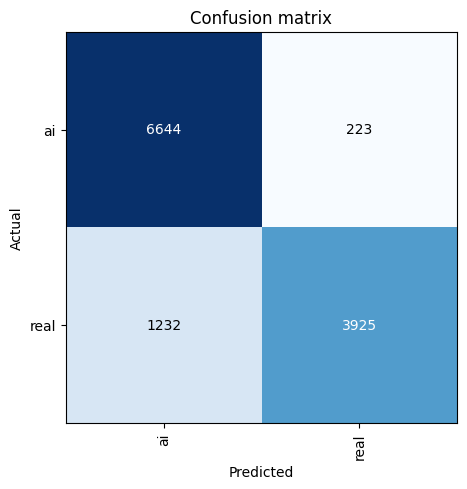

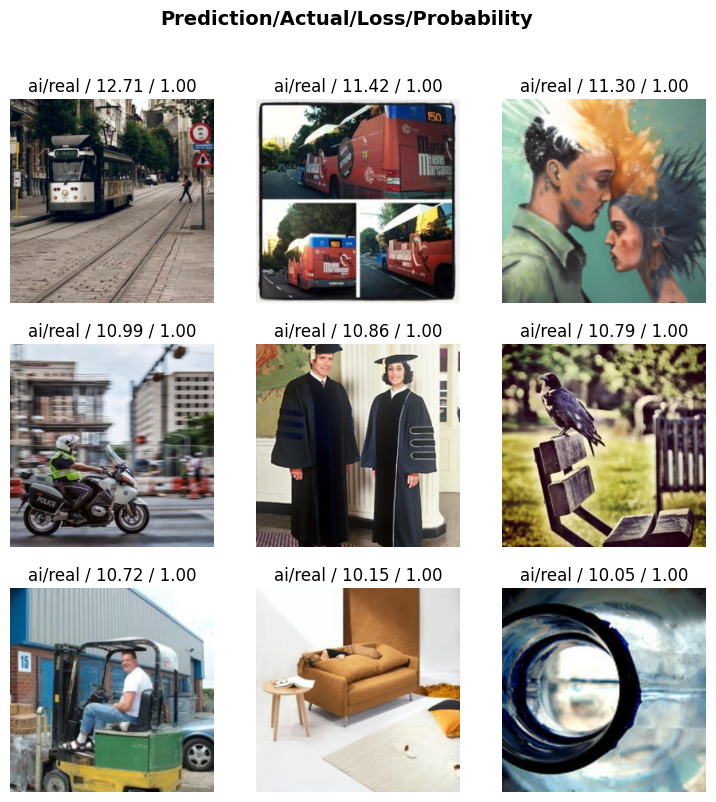

In [55]:
tta_res = []

for arch,details in models.items():
    for item,size in details:
        print('---',arch)
        print(size)
        tta_res.append(train(arch, size, item=item, accum=1, epochs=1))
        gc.collect()
        torch.cuda.empty_cache()


In [56]:
save_pickle('tta_res.pkl', tta_res)


In [57]:
tta_prs = first(zip(*tta_res))

In [58]:
avg_pr = torch.stack(tta_prs).mean(0)

In [66]:
idxs = avg_pr.argmax(dim=1)

In [ ]:
ss = pd.read_csv(path/'sample.csv')
ss['class'] = idxs
ss.to_csv('subm.csv', index=False)
!head subm.csv


filename,class
1.jpg,1
2.jpg,0
3.jpg,0
4.jpg,1
5.jpg,1
6.jpg,0
7.jpg,0
8.jpg,1
9.jpg,0


/tmp/ipykernel_133320/3484199876.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ss['class'] = np.logical_not(idxs)


In [68]:
if not iskaggle:
    from kaggle import api
    api.competition_submit_cli('subm.csv', 'resnet50', comp)

100%|██████████| 52.6k/52.6k [00:01<00:00, 51.6kB/s]


In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(9)

In [51]:
tst_files = get_image_files(tst_path).sorted()
tst_dl = dls.test_dl(tst_files)
